# Roman Urdu Sentiment Analyzer (ML)

In [12]:
!pip show scikit-learn

Name: scikit-learn
Version: 1.8.0
Summary: A set of python modules for machine learning and data mining
Home-page: https://scikit-learn.org
Author: 
Author-email: 
License-Expression: BSD-3-Clause
Location: C:\Users\Muhammad Adnan\Desktop\Roman Urdu Sentiment\venv\Lib\site-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: 


## 1. Import Libraries

In [13]:
import re
import os
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

## 2. Load Dataset

In [14]:
df = pd.read_csv("Roman Urdu Tagged Dataset.csv")
df = df.dropna()
df["Text"] = df["Text"].astype(str)

## 3. Text Cleaning

In [15]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["clean_text"] = df["Text"].apply(clean_text)

## 4. Encode Labels

In [16]:
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["Sentiment (POS/NEG/NEU)"])
print("Classes:", label_encoder.classes_)

Classes: ['Negative' 'Neutral' 'Positive']


## 5. Train-Test Split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    df["clean_text"], df["label"],
    test_size=0.25,
    stratify=df["label"],
    random_state=42
)

## 6. TF-IDF Vectorizer

In [18]:
tfidf = TfidfVectorizer(
    ngram_range=(1, 3),
    max_features=40000,
    min_df=3,
    max_df=0.9,
    sublinear_tf=True
)

In [19]:
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

## 7. Class Weights (Balancing)

In [20]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

Class Weights: {0: np.float64(1.5411632481033999), 1: np.float64(0.6326412918108419), 2: np.float64(1.2979176526265972)}


In [21]:
# 📦 OUTPUT DIRECTORIES
BASE_DIR = "saved_ml_models"
PLOTS_DIR = f"{BASE_DIR}/plots"
REPORTS_DIR = f"{BASE_DIR}/reports"

os.makedirs(PLOTS_DIR, exist_ok=True)
os.makedirs(REPORTS_DIR, exist_ok=True)

## 8. Models + Hyperparameters

In [22]:
models_params = {
    "Logistic Regression": (
        LogisticRegression(max_iter=500, class_weight=class_weights_dict),
        {"C": [0.1, 1, 10]}
    ),
    "SVM": (
        LinearSVC(class_weight=class_weights_dict, max_iter=5000),
        {"C": [0.1, 1, 10]}
    ),
    "Naive Bayes": (
        MultinomialNB(),
        {"alpha": [0.5, 1.0, 1.5]}
    ),
    "Decision Tree": (
        DecisionTreeClassifier(class_weight=class_weights_dict),
        {"max_depth": [None, 10, 20]}
    ),
    "Random Forest": (
        RandomForestClassifier(class_weight=class_weights_dict, n_jobs=-1),
        {"n_estimators": [100, 200]}
    )
}

## 9. Train, Evaluate, SHOW Results


Training Model: Logistic Regression

📄 Classification Report – Logistic Regression
              precision    recall  f1-score   support

    Negative       0.59      0.69      0.64      1187
     Neutral       0.82      0.74      0.78      2890
    Positive       0.72      0.77      0.75      1408

    accuracy                           0.74      5485
   macro avg       0.71      0.73      0.72      5485
weighted avg       0.75      0.74      0.74      5485



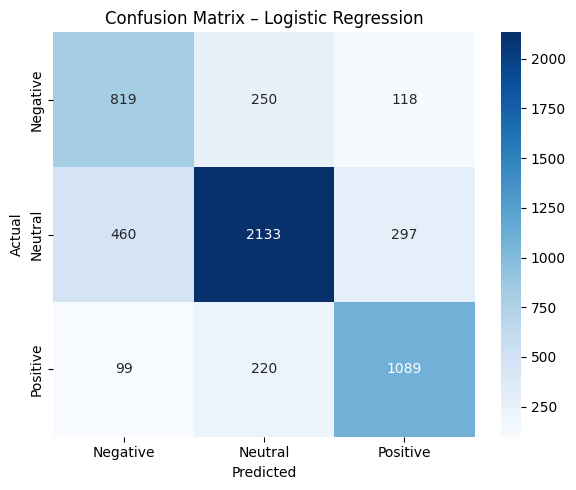


Training Model: SVM

📄 Classification Report – SVM
              precision    recall  f1-score   support

    Negative       0.64      0.61      0.62      1187
     Neutral       0.78      0.80      0.79      2890
    Positive       0.75      0.74      0.74      1408

    accuracy                           0.74      5485
   macro avg       0.72      0.72      0.72      5485
weighted avg       0.74      0.74      0.74      5485



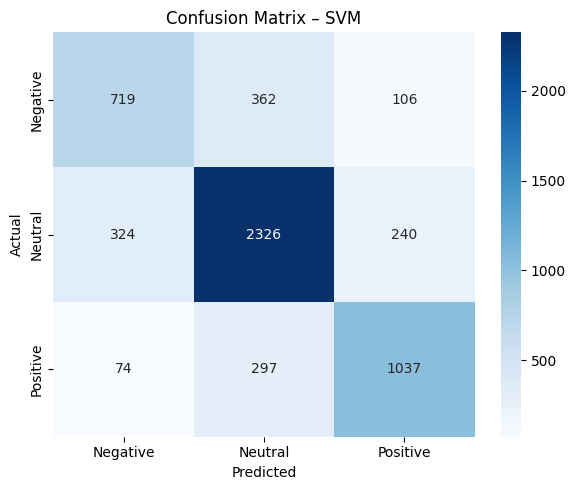


Training Model: Naive Bayes

📄 Classification Report – Naive Bayes
              precision    recall  f1-score   support

    Negative       0.74      0.38      0.51      1187
     Neutral       0.71      0.90      0.79      2890
    Positive       0.78      0.66      0.71      1408

    accuracy                           0.73      5485
   macro avg       0.74      0.65      0.67      5485
weighted avg       0.73      0.73      0.71      5485



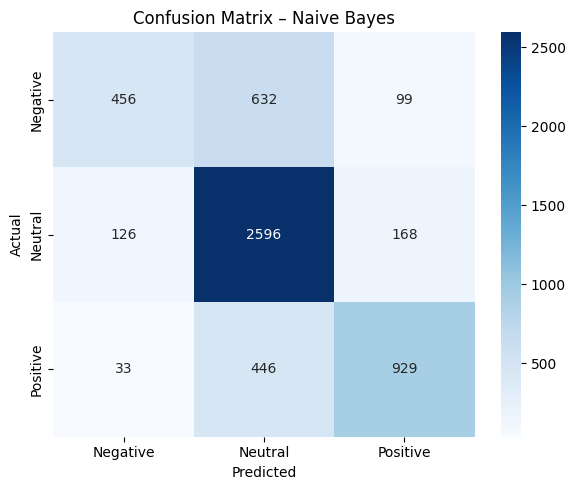


Training Model: Decision Tree

📄 Classification Report – Decision Tree
              precision    recall  f1-score   support

    Negative       0.62      0.37      0.46      1187
     Neutral       0.64      0.87      0.74      2890
    Positive       0.70      0.44      0.54      1408

    accuracy                           0.65      5485
   macro avg       0.65      0.56      0.58      5485
weighted avg       0.65      0.65      0.63      5485



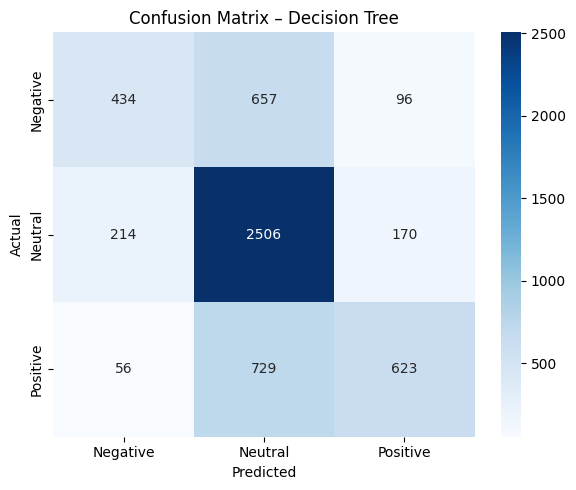


Training Model: Random Forest

📄 Classification Report – Random Forest
              precision    recall  f1-score   support

    Negative       0.66      0.47      0.55      1187
     Neutral       0.72      0.86      0.78      2890
    Positive       0.77      0.64      0.70      1408

    accuracy                           0.72      5485
   macro avg       0.72      0.66      0.68      5485
weighted avg       0.72      0.72      0.71      5485



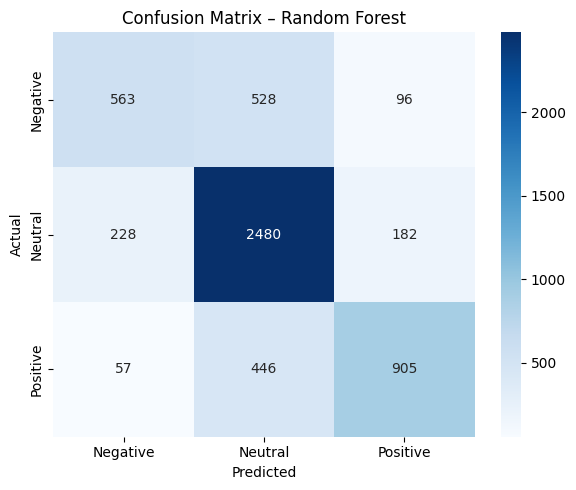

In [23]:
results = {}
trained_models = {}

for name, (model, params) in models_params.items():
    print(f"\n{'='*60}")
    print(f"Training Model: {name}")
    print(f"{'='*60}")

    grid = GridSearchCV(model, params, cv=3, n_jobs=-1, scoring="accuracy")
    grid.fit(X_train_tfidf, y_train)

    best_model = grid.best_estimator_
    trained_models[name] = best_model

    y_pred = best_model.predict(X_test_tfidf)

    acc = accuracy_score(y_test, y_pred)
    results[name] = acc

    # 🔹 SHOW Classification Report
    print(f"\n📄 Classification Report – {name}")
    print(classification_report(
        y_test, y_pred,
        target_names=label_encoder.classes_
    ))

    # 🔹 Save Classification Report
    report_df = pd.DataFrame(
        classification_report(
            y_test, y_pred,
            target_names=label_encoder.classes_,
            output_dict=True
        )
    ).transpose()
    report_df.to_csv(f"{REPORTS_DIR}/{name}_classification_report.csv")

    # 🔹 Confusion Matrix (SHOW + SAVE)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=label_encoder.classes_,
        yticklabels=label_encoder.classes_
    )
    plt.title(f"Confusion Matrix – {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(f"{PLOTS_DIR}/{name}_confusion_matrix.png")
    plt.show()   # 🔥 THIS SHOWS THE MATRIX

## 10. Accuracy Comparison

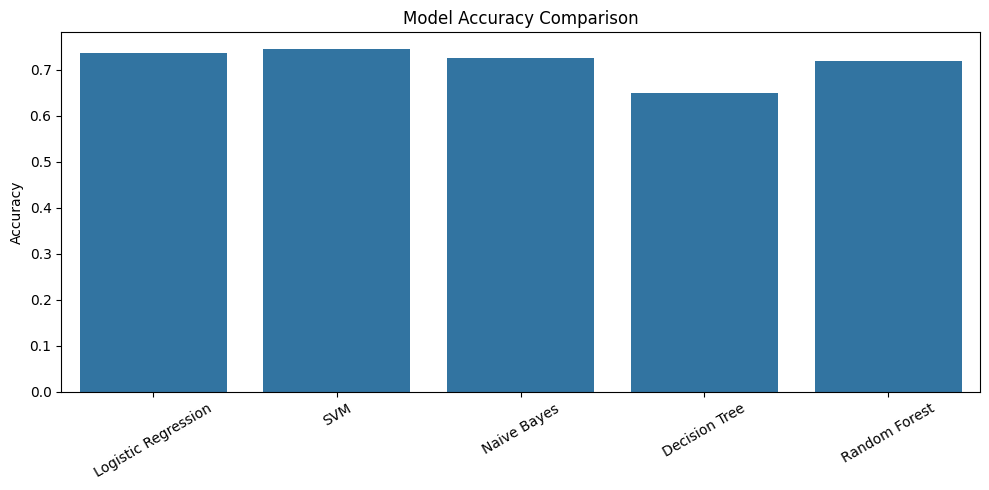

In [24]:
plt.figure(figsize=(10, 5))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.xticks(rotation=30)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.tight_layout()
plt.savefig(f"{PLOTS_DIR}/model_accuracy_comparison.png")
plt.show()

## 11. Save Best Model

In [25]:
best_model_name = max(results, key=results.get)
best_model = trained_models[best_model_name]

print("\n🏆 BEST MODEL:", best_model_name)
print("Accuracy:", results[best_model_name])

joblib.dump(best_model, f"{BASE_DIR}/best_model.joblib")
joblib.dump(tfidf, f"{BASE_DIR}/tfidf_vectorizer.joblib")
joblib.dump(label_encoder, f"{BASE_DIR}/label_encoder.joblib")

with open(f"{BASE_DIR}/metadata.json", "w") as f:
    json.dump({
        "best_model": best_model_name,
        "accuracy": results[best_model_name],
        "all_results": results
    }, f, indent=4)


🏆 BEST MODEL: SVM
Accuracy: 0.7442114858705561


## 12. Prediction Function

In [26]:
# def predict_sentiment(texts):
#     texts = [clean_text(t) for t in texts]
#     X = tfidf.transform(texts)
#     preds = best_model.predict(X)
#     return label_encoder.inverse_transform(preds)

# # Example
# print(predict_sentiment(["yeh mobile bohat acha hai"]))

In [27]:
# !zip -r saved_ml_models.zip /kaggle/working/saved_ml_models

In [28]:
# !zip -r saved_models.zip /kaggle/working/saved_models

In [29]:
MODELS_DIR = "all_models"
os.makedirs(MODELS_DIR, exist_ok=True)

for model_name, model in trained_models.items():
    safe_name = model_name.replace(" ", "_").lower()
    joblib.dump(model, f"{MODELS_DIR}/{safe_name}.joblib")

In [30]:
# !zip -r all_models.zip /kaggle/working/all_models